In [1]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as T

from barlow_twins import BarlowTwins

from augmentation import apply_transforms_inf
from short_video_dataset import ShortVideoDataset

In [2]:
model = torch.load('model.pth')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)

cuda


BarlowTwins(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [4]:
dataset = ShortVideoDataset('video_short_half_res', transform=T.Compose([
    T.ToTensor(),
    T.CenterCrop(size=720)
]))

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    # drop_last=True,
    num_workers=1,
)

In [5]:
embeddings = []

model.eval()
for image in dataloader:
    image = apply_transforms_inf(image).to(device)
    emb = model(image).cpu().detach().flatten()

    embeddings.append(np.array(emb))

In [6]:
len(embeddings)

544

In [7]:
embeddings = np.array(embeddings)

## PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
# pca = PCA(n_components=2)
# pca.fit(embeddings)

# embeddings_red = pca.transform(embeddings)
# X, Y = embeddings_red[:,0], embeddings_red[:,1]

In [10]:
import matplotlib.pyplot as plt

In [11]:
# plt.scatter(X, Y)

In [12]:
# for i in range(len(X)):
#     plt.scatter(X[i], Y[i], color=plt.cm.RdYlBu(i))

## Nearest Neighbours

In [13]:
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import ImageGrid

In [14]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(embeddings)

NearestNeighbors(n_neighbors=10)

In [15]:
random_index = np.random.randint(len(embeddings))
neigh.kneighbors(embeddings[random_index].reshape(1,-1), 10, return_distance=False)

array([[ 96,  80,  77,  78,  83,  93,  90,  75,  88, 100]])

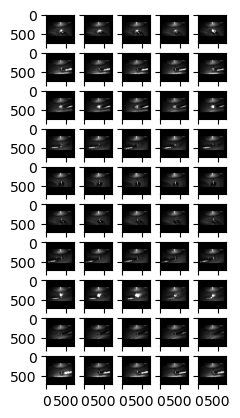

In [20]:
num_samples = 10
num_neighb = 5

fig = plt.figure()
grid = ImageGrid(fig, 111, nrows_ncols=(10,num_neighb), axes_pad=0.1)

for r in range(num_samples):
    random_index = np.random.randint(len(embeddings))
    neighb_index = neigh.kneighbors(embeddings[random_index].reshape(1,-1), num_neighb, return_distance=False)

    for c in range(len(neighb_index[0])):
        im = dataset.__getitem__(neighb_index[0][c])
        im = im.swapaxes(0,-1).swapaxes(0,1)
        grid[num_neighb*r+c].imshow(im)
